## Breast cancer detection using deep learning

In this notebook we are going to use the [Breast Histopathology Images](https://www.kaggle.com/paultimothymooney/breast-histopathology-images) dataset and the `fastai` library for detecting breast cancer. 

**Context**: 

Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.

**About the dataset**:

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.

**Inspiration**:

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.

**Adrian Rosebrock **of **PyImageSearch** has [this wonderful tutorial](https://www.pyimagesearch.com/2019/02/18/breast-cancer-classification-with-keras-and-deep-learning/) on this same topic as well. Be sure to check that out if you have not. I decided to use the `fastai` library and to see how could I improve the predictive performance by incoporating modern deep learning practices. 

Let's take a look at the class distribution of the dataset again - > 

* 198,738 negative examples (i.e., no breast cancer)
* 78,786 positive examples (i.e., indicating breast cancer was found in the patch)

0 indicates `no IDC` (no breast cancer) while 1 indicates `IDC`  (breast cancer) 

As we can see, this is a clear example of *class-imbalance*. But we will start simple and do a lot of experimentation for taking major decisions for the model training and tricking. 

In [1]:
# Get the fastai libraries and other important stuff: https://course.fast.ai/start_colab.html
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# Authenticate Colab to use my Google Drive for data storage and retrieval
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'BreastCancer'

In [3]:
base_dir

'/content/gdrive/My Drive/BreastCancer'

In [0]:
# Change the working directory
%cd /content/gdrive/My\ Drive/BreastCancer

/content/gdrive/My Drive/BreastCancer


In [0]:
# Verify
!pwd

/content/gdrive/My Drive/BreastCancer


Unzip the zipped folder of data by `!unzip /content/gdrive/My\ Drive/BreastCancer/IDC_regular_ps50_idx5.zip`. It will take time. When the process completes, make sure to move the zipped folder to somwhere else (or remove). 

<font color=red>Warning ahead! The unzipping process takes time. So be patient. </font>

In [0]:
!unzip /content/gdrive/My\ Drive/BreastCancer/IDC_regular_ps50_idx5.zip

In [5]:
!find /content/gdrive/My\ Drive/BreastCancer -maxdepth 1 -type d | wc -l

237


### Magics and imports

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import *

import numpy as np
np.random.seed(7)

### Instantiating the data augmentation object with a number of useful transforms

In [0]:
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.3, max_warp=0.3, max_rotate=20., max_zoom=0.05)
len(tfms)

2

### Loading the data in mini batches of 32 (48x48)

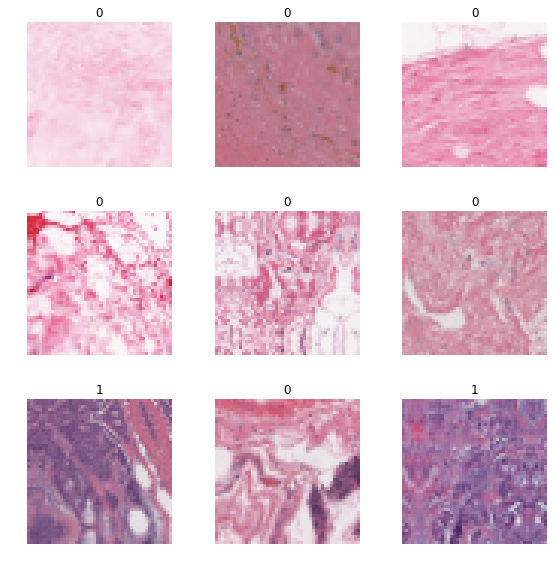

In [0]:
path = '/content/gdrive/My Drive/BreastCancer/'
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid_pct=0.2,
                                  size=48, bs=32).normalize(imagenet_stats)

data.show_batch(rows=3, figsize=(8,8))

Just to remind you - **0 indicates `no IDC` (no breast cancer) while 1 indicates `IDC`  (breast cancer)**.

In [0]:
# Training and validation set splits
data.label_list

LabelLists;

Train: LabelList (222020 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
0,0,0,0,0
Path: /content/gdrive/My Drive/BreastCancer;

Valid: LabelList (55504 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
0,0,0,0,0
Path: /content/gdrive/My Drive/BreastCancer;

Test: None

### Training a pretrained ResNet50 + Mixed precision policy

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 91198710.77it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.360870,0.328003,0.859974,17:58
1,0.326274,0.302966,0.873216,17:06
2,0.317028,0.309457,0.877468,16:06
3,0.288141,0.296124,0.881054,15:32
4,0.300970,0.318085,0.883017,15:41
5,0.298304,0.299441,0.887612,15:21
6,0.298090,0.267250,0.890783,15:21
7,0.292353,0.284676,0.889684,15:33
8,0.277447,0.268594,0.889287,16:06
9,0.286032,0.264215,0.891323,16:06


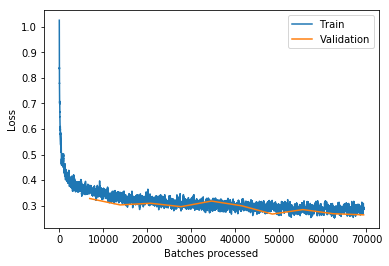

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy]).to_fp16()
learn.fit_one_cycle(10);
learn.recorder.plot_losses()

A mammoth training of **2 hours, 40 minutes and 50 seconds.** 

In [0]:
# Saving the model
learn.save('stage-1-rn50')

### Model's losses, accuracy scores and more

In [0]:
# Model's final validation loss and accuracy
learn.validate()

[0.26421532, tensor(0.8913)]

`tensor(0.8913)` denotes an accuracy score of **89.13%**.

In [0]:
# Model's final training loss and accuracy
learn.validate(learn.data.train_dl)

[0.26750788, tensor(0.8887)]

As mentioned in the very beginning, the dataset suffers from the problem of class-imbalance. And for class-imbalanced datasets, we cannot simply go with the accuracy score. Read about [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox). We will have to consider other metrics like **specificity**, **sensitivity**. Let's start by looking at model's predictions on the validation set. 

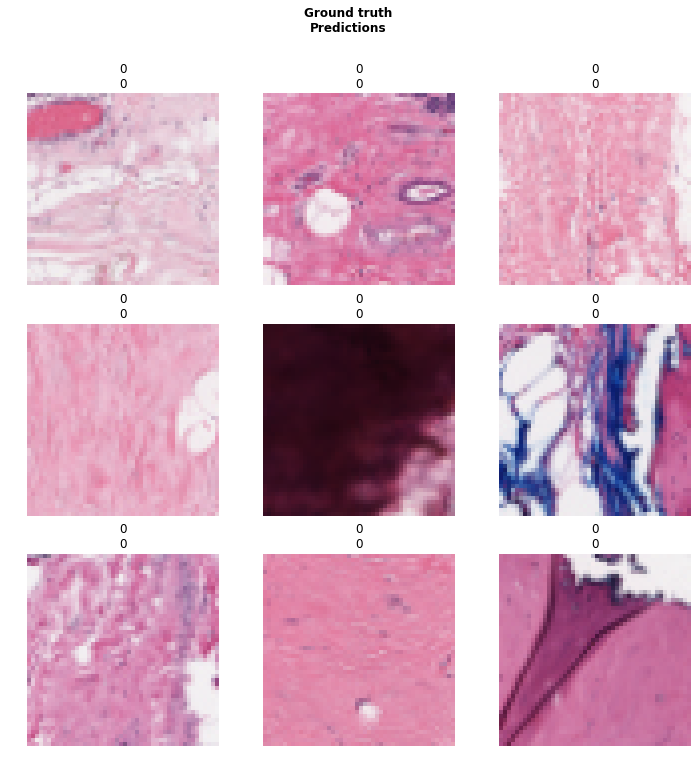

In [0]:
# Looking at model's results
learn.show_results(rows=3)

The above figure presents a few IDC(-) samples from the validation set and along with that also shows model's predictions. Let's now see the top losses incurred by the model during the training process. 

### Model's top losses and confusion matrix

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

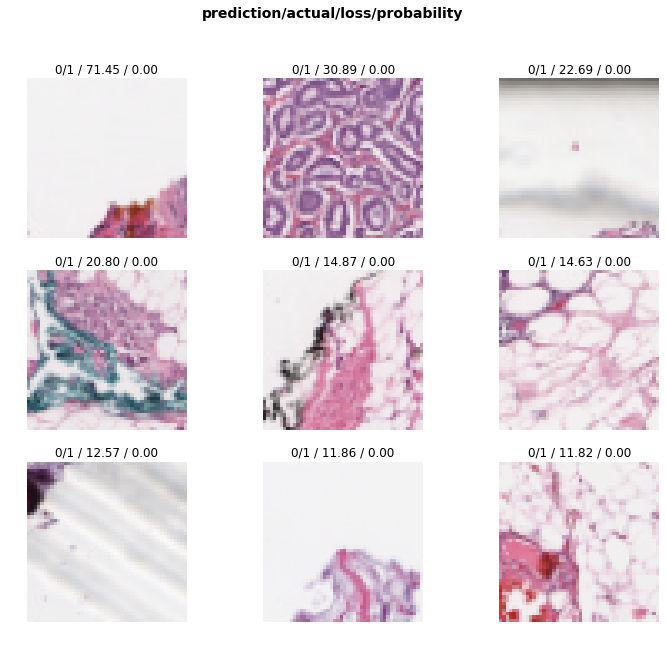

In [0]:
interp.plot_top_losses(9, figsize=(12,10), heatmap=False)

We can see that there are some samples which are originally IDC(+) but the model predicts them as IDC(-). **This is a staggering issue**. 

We need to be really careful with our false negative here — we don’t want to classify someone as “No cancer” when they are in fact “Cancer positive”.

Our false positive rate is also important — we don’t want to mistakenly classify someone as “Cancer positive” and then subject them to painful, expensive, and invasive treatments when they don’t actually need them.

To get a strong hold of how model is doing on false positives and false negatives, we can plot the confusion matrix. 

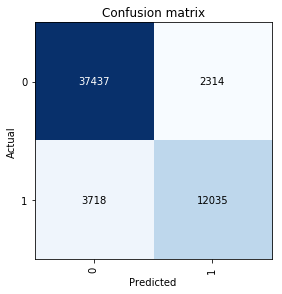

In [0]:
interp.plot_confusion_matrix()

There can be improvements in the model's training instructions so that the model minimizes the false predictions. 

**What can be done?**
- We are using the pre-trained weights of the ResNet50 model. We can train the other layers of the model to make it a bit more specific
- We have trained our model only for a few epochs. A bit more training will definitely help
- We have not used discriminative learning rates i.e. the way of training models using different learning rates across different layers groups
- Assigning class weights in the loss function (cross-entropy in this case)

Before we experiment with all this, let's generate  a classification report of model's performance. 

### Classification report to look at other metrics since there is a class imbalance

In [0]:
ground_truth = []
pred_labels = []

for i in range(len(learn.data.valid_ds)):
  temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
  temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
  pred_labels.append(temp_pred)
  ground_truth.append(temp_truth)
  
assert len(pred_labels) == len(ground_truth)

In [0]:
from sklearn.metrics import classification_report

print(classification_report(ground_truth, pred_labels, target_names=data.classes))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93     39751
           1       0.84      0.76      0.80     15753

   micro avg       0.89      0.89      0.89     55504
   macro avg       0.87      0.85      0.86     55504
weighted avg       0.89      0.89      0.89     55504



As we can see the model's [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) could have been much better. Adrian's model was able to achieve a better recall - 

![](https://i.ibb.co/bgBBFJc/Screen-Shot-2019-05-03-at-9-30-39-PM.png)

We will now start by finding an optimal learning rate for the model. 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


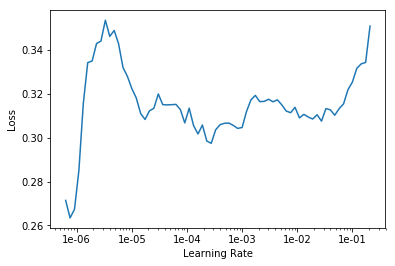

In [0]:
learn.lr_find();
learn.recorder.plot()

We now have an idea of what could be a good learning rate for the model. We will now unfreeze the first layer groups of the model and will allow it to fully train. We will train it using discriminative learning rates for five epochs. 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice((1e-06+1e-05)/2, (1e-06+1e-05)/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.286894,0.280717,0.891720,16:41
1,0.275945,0.259702,0.893936,16:40
2,0.292649,0.255512,0.896314,16:58
3,0.268218,0.256980,0.896602,16:46
4,0.287856,0.252070,0.896314,16:53


Another **1 hours and 26** minutes of training. 

In [0]:
# Save model
learn.save('stage-2-more-rn50')

In [0]:
# Looking at the classification report 

ground_truth = []
pred_labels = []

for i in range(len(learn.data.valid_ds)):
  temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
  temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
  pred_labels.append(temp_pred)
  ground_truth.append(temp_truth)
  
assert len(pred_labels) == len(ground_truth)

print(classification_report(ground_truth, pred_labels, target_names=data.classes))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     39751
           1       0.83      0.79      0.81     15753

   micro avg       0.90      0.90      0.90     55504
   macro avg       0.88      0.87      0.87     55504
weighted avg       0.90      0.90      0.90     55504



As we can see the recall has improved. 

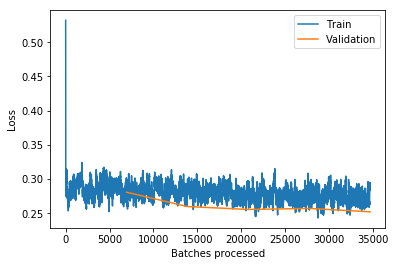

In [0]:
# Loss vs. Batches 
learn.recorder.plot_losses()

### A bit more training with the previously saved weights

epoch,train_loss,valid_loss,accuracy,time
0,0.290580,0.259061,0.895107,17:29
1,0.275584,0.257542,0.896620,17:17


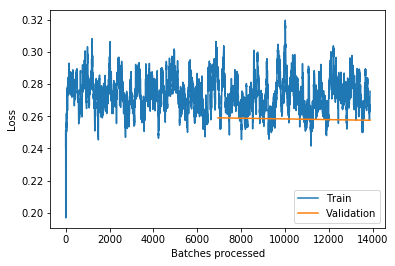

In [0]:
learn.load('stage-2-more-rn50')
learn.fit_one_cycle(2, max_lr=slice((1e-06+1e-05)/2));
learn.recorder.plot_losses()

The loss function's behavior is changing. This is a good sign. Let's see the classification report for this one as well. 

In [0]:
ground_truth = []
pred_labels = []

for i in range(len(learn.data.valid_ds)):
  temp_pred = str(learn.predict(learn.data.valid_ds[i][0])[0])
  temp_truth = str(learn.data.valid_ds[i]).split('), ', 1)[1].replace('Category ', '').replace(')', '')
  pred_labels.append(temp_pred)
  ground_truth.append(temp_truth)
  
assert len(pred_labels) == len(ground_truth)

print(classification_report(ground_truth, pred_labels, target_names=data.classes))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     39751
           1       0.84      0.79      0.81     15753

   micro avg       0.90      0.90      0.90     55504
   macro avg       0.88      0.86      0.87     55504
weighted avg       0.90      0.90      0.90     55504



The recall does not improves for the IDC(+) samples. 

In [0]:
# Save model
learn.save('stage-3-more-rn50')

### Adding weights to the imbalanced class (IDC(+)) and assigning it to the loss function

In [0]:
from torch import nn

weights = [0.4, 1]
class_weights=torch.FloatTensor(weights).cuda()

In [0]:
learn.load('stage-3-more-rn50')
learn.loss_function = nn.CrossEntropyLoss(weight=class_weights)
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time


### Model's architectural summary

In [0]:
learn.summary()